# Medical Images Project
---
This proposal 3 objectives:  
1. DICOM loading and visualization
2. 3D Image Segmentation
3. 3D Rigid Coregistration

As we can choose 2 of the 3 objectives, we choose 1 and 2.

## DICOM loading and visualization section

**a) Download the sample RadCTTACEomics DDDD (click here), where DDDD is the sample associated to you (see assignment in Aula Digital).**  

RadCTTACEomics_1447
  
- **Reference image**: 11_AP_Ax5.00mm
- **Input image**: 31_EQP_Ax5.00mm


In [11]:
import os
import pydicom
import highdicom as hd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import matplotlib.animation as animation
import scipy.ndimage
from matplotlib import colors as mcolors
import cv2
import SimpleITK as sitk

In [2]:
#Constants
path_reference="../1447/11_AP_Ax5.00mm/"
path_input="../1447/31_EQP_Ax5.00mm/"
path_roi_liver="../1447/11_AP_Ax5.00mm_ManualROI_Liver.dcm"
path_roi_tumor="../1447/11_AP_Ax5.00mm_ManualROI_Tumor.dcm"

**b) Visualize it with the help of a third party DICOM visualizer (3D-Slicer is recommended).**   
To help use with the visualization we follow the advices from:
3rd party visualization: https://spujol.github.io/SlicerDICOMTutorial/3DSlicer_DICOMTutorial_SoniaPujol.pdf


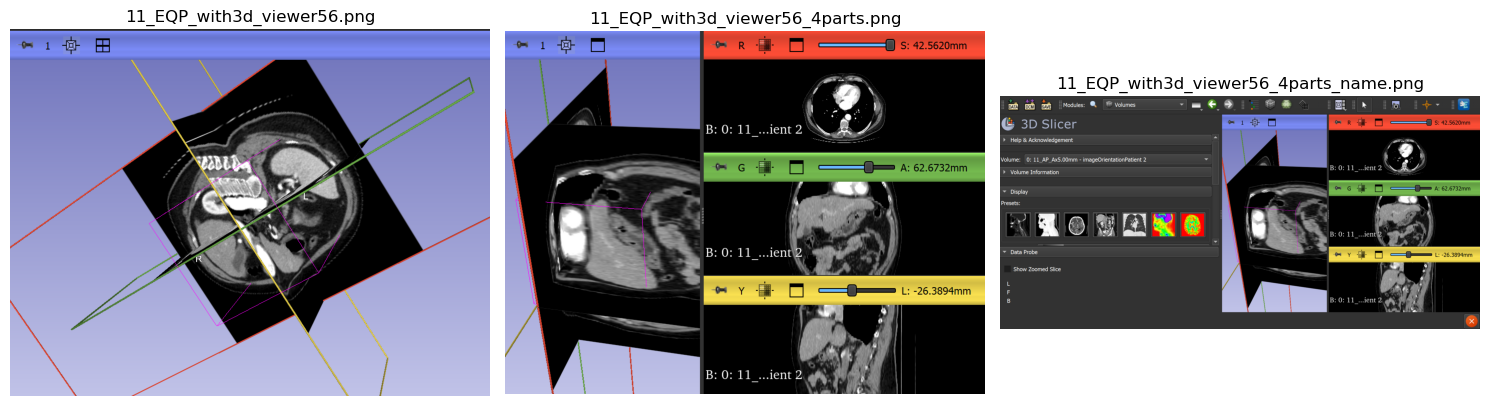

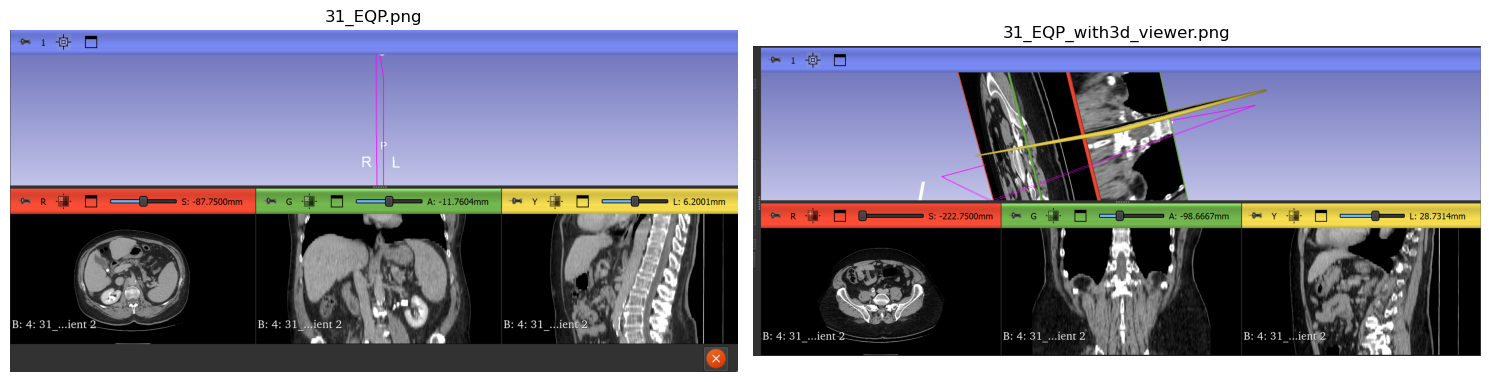

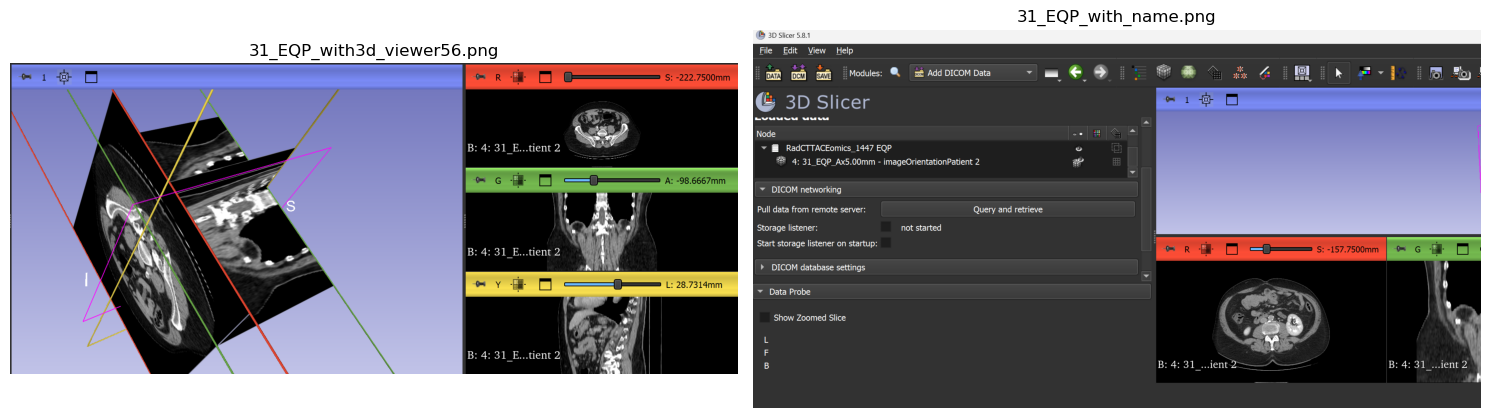

In [5]:

folder_path = "3d_slicer_photos/"
image_paths = list(Path(folder_path).glob('*.png'))  


group_pattern = [3, 2, 2]
groups = []
start_idx = 0

for count in group_pattern:
    end_idx = start_idx + count
    groups.append(image_paths[start_idx:end_idx])
    start_idx = end_idx

for group in groups:
    plt.figure(figsize=(15, 5))
    
    for idx, img_path in enumerate(group, 1):
        img = Image.open(img_path)
        
        plt.subplot(1, len(group), idx)
        plt.imshow(img)
        plt.axis('off')
        plt.title(img_path.name)
    
    plt.tight_layout()
    plt.show()


Is need to visualize this as in 3d slicer, using python

**c) Load the reference CT image (pydicom) and the associated segmentations (highdicom)**  
Rearrange the image and segmentation ‘pixel array’ given by PyDicom based on the headers. Some relevant headers include:  
- ‘Acquisition Number’.
- ‘Slice Index’.
- ‘Per-frame Functional Groups Sequence’ -> ‘Image Position Patient’.
- ‘Segment Identification Sequence’ -> ‘Referenced Segment Number’
---


To order the attributes consistently while considering one axis from the 3D position, follow these steps:

- Acquisition Number: Start by sorting images based on the acquisition number. This ensures that images from different scans (e.g., pre-contrast vs. post-contrast) are grouped separately. A smaller acquisition number indicates an earlier scan, so it should come first.

- Slice Index: Within each acquisition group, sort the images by their slice index. This arranges the slices in the correct sequential order for reconstructing the 3D volume.

- Image Position Patient (Specific Axis): If there is a tie in the slice index, sort the images based on one specific axis from the 3D position (e.g., the z-axis for axial slices). Consistently using one axis ensures proper alignment of slices in 3D space along that dimension.

- Referenced Segment Number: Finally, if all previous attributes are identical, sort by the referenced segment number to distinguish between different anatomical regions or structures within the image.

Headers study: This approach ensures consistency by focusing on a single axis for spatial alignment while maintaining a hierarchical ordering structure.
Headers of the reference image and of the segmented image of the liver have been manually reviewed. In the first of the 4 data requested, only the first 3 can be obtained. And in the case of the segmented image the position of the patient and the Referenced Segment Number.

example=pydicom.dcmread("../1447/11_AP_Ax5.00mm/dicom-00001.dcm")  
example_image = example.pixel_array

In [16]:
def load_dicom_files(directory):
    files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.dcm')]
    return [pydicom.dcmread(f) for f in files]

def extract_read_headers(dcm_files):
    headers = []
    for dcm_file in dcm_files:
        acquisition_number = dcm_file.get('AcquisitionNumber', None)
        slice_index = dcm_file.InstanceNumber
        img_position_patient = dcm_file.ImagePositionPatient if 'ImagePositionPatient' in dcm_file else None
        img_orientation_patient=dcm_file.ImageOrientationPatient
        slice_location=dcm_file.SliceLocation
        headers.append({
            'file': dcm_file,
            'acquisition_number': acquisition_number,
            'slice_index': slice_index,
            'image_position_patient': img_position_patient,
            'img_orientation_patient':img_orientation_patient,
            'slice_location':slice_location
        })
    return headers
def check_is_single_adquisition(headers):
    unique_acquisition_numbers = set()
    for header in headers:
        unique_acquisition_numbers.add(header['acquisition_number'])
    if len(unique_acquisition_numbers)==1:   
        print(f"The slices of the CT image contain only a single acquisition")
    else:
        print(f"The slices of the CT image contain more than one acquisition")
        
def rearrange_img_segmentation_by_headers(headers):
    # Sort headers based on the relevant attributes
    sorted_headers = sorted(headers, key=lambda x: (
        x['acquisition_number'] if x['acquisition_number'] is not None else 0,
        x['slice_index'] if x['slice_index'] is not None else 0,
        x['image_position_patient'][2] if x['image_position_patient'] is not None else 0,  # Sort by Z-axis
    ))

    return sorted_headers
def extract_pixel_arrays(sorted_headers):
    return np.stack([header['file'].pixel_array for header in sorted_headers])

def visualize_sorted_slices(sorted_headers, num_slices=5):
    fig, axes = plt.subplots(1, num_slices, figsize=(15, 5))
    for i in range(num_slices):
        axes[i].imshow(sorted_headers[i]['file'].pixel_array, cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f"Slice {i+1}")
    plt.show()


def save_sorted_images(sorted_headers, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for i, header in enumerate(sorted_headers):
        output_path = os.path.join(output_folder, f"sorted_image_{i}.dcm")
        header['file'].save_as(output_path)

def show_ordered_headers(sorted_headers):
    for i, header in enumerate(sorted_headers):
        print(f"Header {i+1}:")
        print(f"  Acquisition Number: {header['acquisition_number']}")
        print(f"  Slice Index: {header['slice_index']}")
        print(f"  Image Position Patient: {header['image_position_patient']}")
        print(f"  Image Orientation Patient: {header['img_orientation_patient']}")
        print(f"  Slice location: {header['slice_location']}")
    print(f"  Array Shape from reference image: {pixel_arrays.shape}")


In [17]:
dcm_files = load_dicom_files(path_reference)
headers = extract_read_headers(dcm_files)
check_is_single_adquisition(headers)
sorted_headers = rearrange_img_segmentation_by_headers(headers)
pixel_arrays = extract_pixel_arrays(sorted_headers)
show_ordered_headers(sorted_headers)

The slices of the CT image contain only a single acquisition
Header 1:
  Acquisition Number: 1
  Slice Index: 1
  Image Position Patient: [5.797, -187.399, 115.75]
  Image Orientation Patient: [0.000000, 1.000000, 0.000000, 0.000000, 0.000000, -1.000000]
  Slice location: -5.797653
Header 2:
  Acquisition Number: 1
  Slice Index: 2
  Image Position Patient: [-200.202, -194.642, 42.562]
  Image Orientation Patient: [1.000000, 0.000000, 0.000000, 0.000000, 1.000000, 0.000000]
  Slice location: 42.562500
Header 3:
  Acquisition Number: 1
  Slice Index: 3
  Image Position Patient: [-200.202, -194.642, 37.562]
  Image Orientation Patient: [1.000000, 0.000000, 0.000000, 0.000000, 1.000000, 0.000000]
  Slice location: 37.562500
Header 4:
  Acquisition Number: 1
  Slice Index: 4
  Image Position Patient: [-200.202, -194.642, 32.562]
  Image Orientation Patient: [1.000000, 0.000000, 0.000000, 0.000000, 1.000000, 0.000000]
  Slice location: 32.562500
Header 5:
  Acquisition Number: 1
  Slice Ind

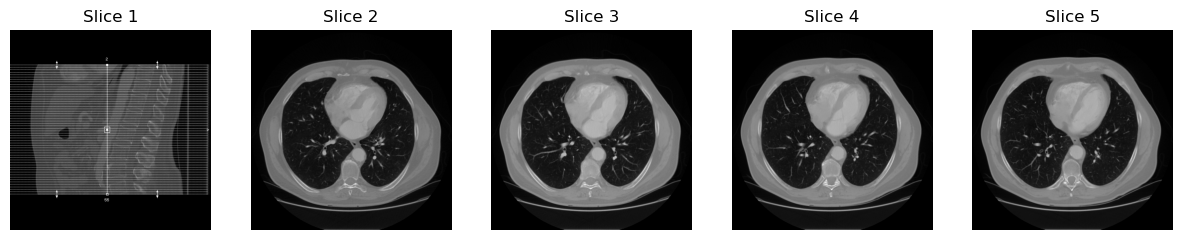

In [18]:
visualize_sorted_slices(sorted_headers)

As you can see we have 55 slices of the reference image, and its height and width is 512x512. We can also see how the first slice is the most different from the others in both orientation and patient position.

**Segmented images section**

---
Liver and tumor ROI  reading the headers obtaing Z position from the patient and Referenced Segment Number. It will first be used to order by the patient's z-position, then by the Referenced Segment Number. This is Z position, descending as in the reference image.

In [19]:
def read_order_seg_header(seg_file):
    seg_data = []
    shared = seg_file.SharedFunctionalGroupsSequence[0]
    img_orientation_patient = shared.PlaneOrientationSequence[0].ImageOrientationPatient
    slice_thickness = shared.PixelMeasuresSequence[0].SliceThickness
    pixel_spacing = shared.PixelMeasuresSequence[0].PixelSpacing
    for idx, frame in enumerate(seg_file.PerFrameFunctionalGroupsSequence):
        #position = float(frame.PlanePositionSequence[0].ImagePositionPatient[2])
        img_position_patient = frame.PlanePositionSequence[0].ImagePositionPatient
        referenced_segment_number = frame.SegmentIdentificationSequence[0].ReferencedSegmentNumber
        
        seg_data.append({
            'file': idx,
            'image_position_patient': img_position_patient,
            'referenced_segment_number': referenced_segment_number
        })
        seg_data=rearrange_img_segmentation_by_headers(seg_data)
    return seg_data
    
def rearrange_img_segmentation_by_headers(headers):
    sorted_headers = sorted(headers, key=lambda x: (
    -x['image_position_patient'][2] if x['image_position_patient'] is not None else 0,
    x['referenced_segment_number'] if x['referenced_segment_number'] is not None else 0))

    return sorted_headers
    
def order_pixel_data(seg_data, pixel_data):
    sorted_indices = [item['file'] for item in seg_data]
    sorted_pixel_data = pixel_data[sorted_indices, :, :]
    return sorted_pixel_data

def visualize_sorted_slices(sorted_pixel_arrays, num_slices=5):
    fig, axes = plt.subplots(1, num_slices, figsize=(15, 5))
    for i in range(num_slices):
        axes[i].imshow(sorted_pixel_arrays[i], cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f"Slice {i+1}")
    plt.show()

def show_seg_header(sorted_headers):
    for i,item in enumerate(sorted_headers):
        print(f"Header {i+1}:")
        print(f"   Position Patient: {item['image_position_patient']}")
        print(f"  Referenced Segment Number: {item['referenced_segment_number']}")

In [20]:
liver_segmentation = pydicom.dcmread(path_roi_liver)
liver_image = liver_segmentation.pixel_array

In [21]:
seg_data=read_order_seg_header(liver_segmentation)
show_seg_header(seg_data)
sorted_pixel_data=order_pixel_data(seg_data,liver_image)
print(f"Array Shape from liver segmentation image: {liver_image.shape}")

Header 1:
   Position Patient: [-200.202, -194.642, 7.562]
  Referenced Segment Number: 1
Header 2:
   Position Patient: [-200.202, -194.642, 2.562]
  Referenced Segment Number: 1
Header 3:
   Position Patient: [-200.202, -194.642, -2.437]
  Referenced Segment Number: 1
Header 4:
   Position Patient: [-200.202, -194.642, -7.437]
  Referenced Segment Number: 1
Header 5:
   Position Patient: [-200.202, -194.642, -12.437]
  Referenced Segment Number: 1
Header 6:
   Position Patient: [-200.202, -194.642, -17.437]
  Referenced Segment Number: 1
Header 7:
   Position Patient: [-200.202, -194.642, -22.437]
  Referenced Segment Number: 1
Header 8:
   Position Patient: [-200.202, -194.642, -27.437]
  Referenced Segment Number: 1
Header 9:
   Position Patient: [-200.202, -194.642, -32.437]
  Referenced Segment Number: 1
Header 10:
   Position Patient: [-200.202, -194.642, -37.437]
  Referenced Segment Number: 1
Header 11:
   Position Patient: [-200.202, -194.642, -42.437]
  Referenced Segment Nu

In [22]:
tumor_segmentation = pydicom.dcmread(path_roi_tumor)
tumor_image = tumor_segmentation.pixel_array

In [23]:
seg_tumor_data=read_order_seg_header(tumor_segmentation)
show_seg_header(seg_tumor_data)
sorted_tumor_pixel_data=order_pixel_data(seg_tumor_data,tumor_image)
print(f"Array Shape from tumor segmentation image: {tumor_image.shape}")

Header 1:
   Position Patient: [-200.202, -194.642, -7.437]
  Referenced Segment Number: 1
Header 2:
   Position Patient: [-200.202, -194.642, -12.437]
  Referenced Segment Number: 1
Header 3:
   Position Patient: [-200.202, -194.642, -17.437]
  Referenced Segment Number: 1
Header 4:
   Position Patient: [-200.202, -194.642, -22.437]
  Referenced Segment Number: 1
Header 5:
   Position Patient: [-200.202, -194.642, -42.437]
  Referenced Segment Number: 1
Header 6:
   Position Patient: [-200.202, -194.642, -47.437]
  Referenced Segment Number: 1
Header 7:
   Position Patient: [-200.202, -194.642, -52.437]
  Referenced Segment Number: 1
Header 8:
   Position Patient: [-200.202, -194.642, -57.437]
  Referenced Segment Number: 1
Header 9:
   Position Patient: [-200.202, -194.642, -62.437]
  Referenced Segment Number: 1
Header 10:
   Position Patient: [-200.202, -194.642, -67.437]
  Referenced Segment Number: 1
Header 11:
   Position Patient: [-200.202, -194.642, -77.437]
  Referenced Segme

Referenced Segment Number, is from the segmentation data, then we have to use path_roi_tumor and path_roi_liver.  
As we can see in both segmented images we do not have the same number of pixel arrays, in the reference image there are about 55, and in the liver segmentation there are 40, and in the tumor one there are 13, so it is not possible to make a simple reslice. As reference data we have the position of the patient, but in the reference image there are about 55 different Z positions, so they will not all coincide. 

---
Falta: Reslice the the liver and tumor file to fit to the reference image grid, to ensure every voxel in the mask corresponds to the correct voxel in the image.
It is necessary to obtain the data related to the space: PixelSpacing, SliceThickness, ImagePositionPatient, ImageOrientationPatient.

In [78]:
def extract_ordered_dcm_files(sorted_headers):
    return [header['file'] for header in sorted_headers]
def reorder_roi_match_file(sorted_headers,pixel_array,resliced_roi, dcm_seg):
    # Obtinning the slices, height and width from the reference pixel array
    shape = pixel_array.shape
    
    dcm_files=extract_ordered_dcm_files(sorted_headers)
    # Obtaining Z position from the patient
    ref_positions = [float(dcm.ImagePositionPatient[2]) for dcm in dcm_files]
    ref_pos_to_index = {z: idx for idx, z in enumerate(ref_positions)}
    # Initialization of the mask
    seg_mask = np.zeros(shape, dtype=dcm_seg.pixel_array.dtype)
    for frame_idx, frame in enumerate(dcm_seg.PerFrameFunctionalGroupsSequence):
        # Obtaining Z position from the patient from the mask
        mask_z = float(frame.PlanePositionSequence[0].ImagePositionPatient[2])
        # Find the corresponding table of contents in the original volume
        if mask_z in ref_pos_to_index:
            vol_idx = ref_pos_to_index[mask_z]
            # Insert the mask slice in the correct position.
            seg_mask[vol_idx] = resliced_roi[frame_idx]
        else:
            print(f"Warning: No match found for Z position={mask_z}")
    return seg_mask

In [30]:
liver_mask=reorder_roi_match_file(sorted_headers,pixel_arrays,liver_image,liver_segmentation)

In [31]:
tumor_mask=reorder_roi_match_file(sorted_headers,pixel_arrays,tumor_image,tumor_segmentation)

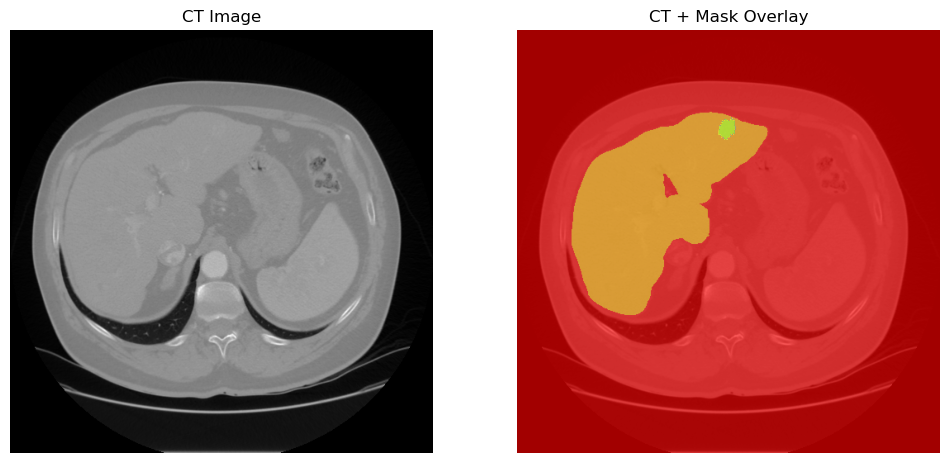

In [85]:
slice_idx =20

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("CT Image")
plt.imshow(pixel_arrays[slice_idx], cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("CT + Mask Overlay")
plt.imshow(pixel_arrays[slice_idx], cmap='gray')
plt.imshow(tumor_mask[slice_idx], cmap='prism', alpha=0.4)  
plt.imshow(liver_mask[slice_idx], cmap='autumn', alpha=0.4)  # Mask in color, semi-transparent
plt.axis('off')

plt.show()


**4 ROIs in the segmented image**
it is stated that there are about 4 rois in the segmentation, and in the case of liver segmentation we only have about 30 records, so I cannot get how many records each ROI has since it is not a division with remainder 0, the same for the tumor.

---
In DICOM SEG files, the actual label images (segmentations) are stored in the pixel data, not in the header itself.  
Durante la revisión de los headers vemos que los SegmentNumber (0062, 0004) solo tiene el numero: 1 solo se repite una vez.
(0062, 0005) Segment Label tiene el valor Liver, y solo hay uno.
SegmentDescription (0062,0006) no esta.
Por tanto si se establece que hay 4 ROIs deberia obtenerse calculo con los registros, ya que tenemos 30 registros /4, pero el valor resultado no es un int.

In [183]:
def apply_threshold(img, threshold=0.1):
    _, thresh = cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY_INV)
    return thresh
def connected_components(thresh_image):
    num_labels, labels_img = cv2.connectedComponents(thresh_image.astype(np.uint8))
    return num_labels, labels_img
def show_ROI_original_img(roi_img, original):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    axes[0].imshow(roi_img, cmap='nipy_spectral')
    axes[0].set_title('roi_img')
    axes[0].axis('off')
    axes[1].imshow(original, cmap='gray')
    axes[1].set_title('original')
    axes[1].axis('off')

3


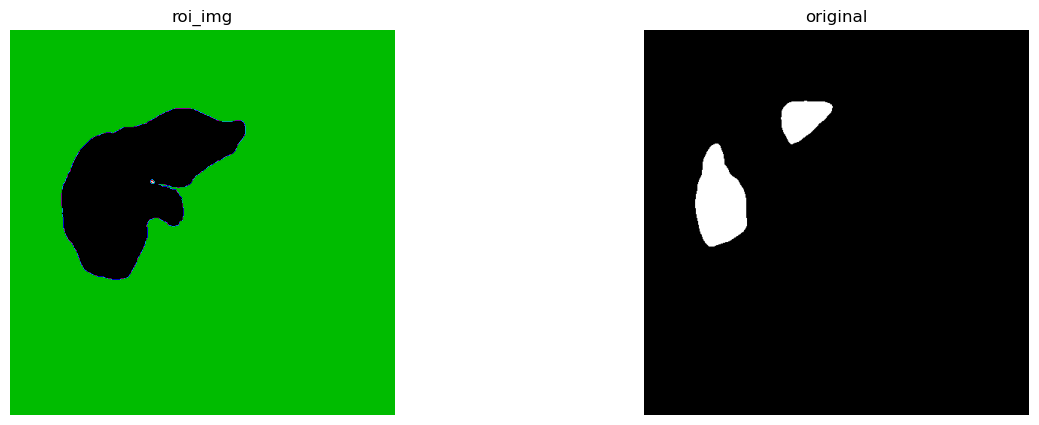

In [187]:

thresh_liver=apply_threshold(liver_image[20])
num_labels, labels_img=connected_components(thresh_liver)
show_ROI_original_img(labels_img,liver_image[6])
print(num_labels)

**d) Create an animation (e.g. gif file) with a rotating Maximum Intensity Projection on the
coronal-sagittal planes, visualizing the tumoral mask.**

In order to perform image enhancement, window center and windown width must be obtained.


In [32]:
def get_windowing(dcm):
    try:
        window_center = dcm.WindowCenter
        window_width = dcm.WindowWidth
        print(f"window_center: {window_center}", f"window_width: {window_width}")
        return window_center, window_width
    except AttributeError:
        # Estimate windowing if not present WindowCenter, and WindowWidth
        pixels = dcm.pixel_array
        max_value = np.max(pixels)
        min_value = np.min(pixels)
        window_center = (max_value + min_value) / 2
        window_width = max_value - min_value
        return window_center, window_width

def apply_windowing(pixel_array, window_center, window_width):
    lower_bound = window_center - window_width / 2
    upper_bound = window_center + window_width / 2
    windowed_array = np.clip(pixel_array, lower_bound, upper_bound)
    return windowed_array

In [33]:
window_center, window_width = get_windowing(dcm_files[0])
windowed_ct_images = np.array([apply_windowing(img, window_center, window_width) for img  in pixel_arrays])

window_center: 40 window_width: 400


Check planes on the reference image: To check the correct aplication of the aspect, and planes:  
https://github.com/pydicom/pydicom/blob/main/examples/image_processing/reslice.py
Pixel_mm  
- pixel_mm (x): Pixel Spacing (0028,0030) - spacing between columns (mm)
- pixel_mm[1] (y): Pixel Spacing (0028,0030) - spacing between rows (mm)
- pixel_mm[2] (z): Slice Thickness (0018,0050) - spacing between slices (mm)

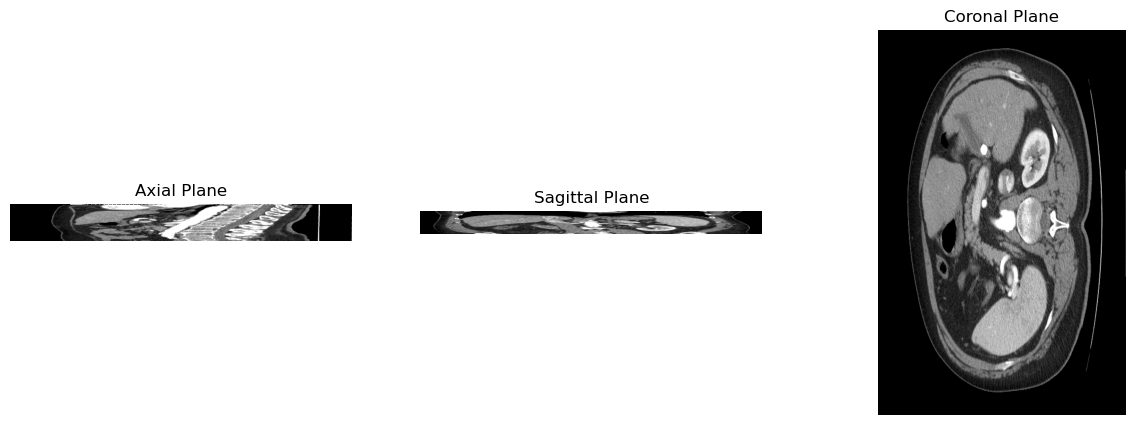

In [107]:
def obtain_space_data(images):
    sample_img=images[0]
    pixel_spacing = sample_img.PixelSpacing  #is an array for the x and y 
    space_between_slices=sample_img.get('SpacingBetweenSlices', None)
    slice_thickness = sample_img.SliceThickness
    return pixel_spacing, space_between_slices, slice_thickness
def obtain_aspects_planes(images):
    pixel_spacing, space_between_slices, slice_thickness=obtain_space_data(images)
    axial_aspect_ratio = pixel_spacing[1] / pixel_spacing[0]
    sagittal_aspect_ratio = pixel_spacing[1]/slice_thickness
    coronal_aspect_ratio = slice_thickness / pixel_spacing[0]
    return axial_aspect_ratio,sagittal_aspect_ratio, coronal_aspect_ratio
def obtain_pixel_mm(images):
    ## pixel_len_mm = [slice_thickness, row_spacing, col_spacing]
    pixel_spacing, space_between_slices, slice_thickness=obtain_space_data(images)
    return [pixel_spacing[0],pixel_spacing[1],slice_thickness]
    
def visualize_planes(ct_volume,axial_aspect_ratio, aspect_ratio_sagittal, aspect_ratio_coronal):
   
    # Obtaining planes
    axial_plane = ct_volume[:, :, ct_volume.shape[2] // 2]
    sagittal_plane = ct_volume[:, ct_volume.shape[1] // 2, :]
    coronal_plane = ct_volume[ct_volume.shape[0] // 2, :, :].T

    '''
    Planes based on the excercises
    axial_plane = ct_volume[ct_volume.shape[0] // 2, :, :]
    sagittal_plane = ct_volume[:, :, ct_volume.shape[2] // 2]
    coronal_plane = ct_volume[:, ct_volume.shape[1] // 2, :]
    '''
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    # Visualize planes with aspect
    axes[0].imshow(axial_plane, cmap='gray', aspect=axial_aspect_ratio)
    axes[0].set_title('Axial Plane')
    axes[0].axis('off')
    
    axes[1].imshow(sagittal_plane, cmap='gray', aspect=aspect_ratio_sagittal)
    axes[1].set_title('Sagittal Plane')
    axes[1].axis('off')
    
    axes[2].imshow(coronal_plane, cmap='gray', aspect=aspect_ratio_coronal)
    axes[2].set_title('Coronal Plane')
    axes[2].axis('off')

    plt.show()
    
axial_aspect_ratio,aspect_ratio_sagittal, aspect_ratio_coronal=obtain_aspects_planes(dcm_files)
pixel_mm=obtain_pixel_mm(dcm_files)
visualize_planes(windowed_ct_images,axial_aspect_ratio, aspect_ratio_sagittal, aspect_ratio_coronal)



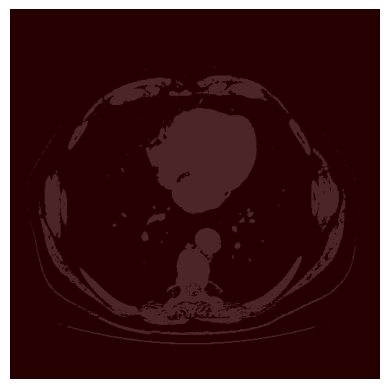

In [112]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib


background = windowed_ct_images[idx]
mask1 = liver_mask[idx]
mask2 = tumor_mask[idx]


alpha1 = 0.5  
alpha2 = 0.7  
# Selecciona el colormap
cmap_function = matplotlib.colormaps['bone']
cmap_function2 = matplotlib.colormaps['prism']
cmap_function3 = matplotlib.colormaps['bone']

# Aplica el colormap a cada capa y convierte a RGB (valores entre 0 y 1)
background_rgb = cmap_function(background)[..., :3]
mask1_rgb = cmap_function2(mask1)[..., :3]
mask2_rgb = cmap_function3(mask2)[..., :3]

#C_final= background_rgb * (1 - alpha1 * mask1_rgb) + mask1_rgb * alpha1
#C_final= background_rgb * (1 - alpha2 * mask2_rgb) + mask2_rgb * alpha2
# Alpha blending
C1 = mask1_rgb * alpha1 + background_rgb * (1 - alpha1)
C_final = mask2_rgb * alpha2 + C1 * (1 - alpha2)

# Visualiza el resultado
plt.imshow(C_final)
plt.axis('off')
plt.show()


In [106]:
def create_mip(volume, axis):
    return np.max(volume, axis=axis)

def obtain_mip_planes(volume):
    mip_axial = create_mip(volume, axis=0)
    mip_coronal = create_mip(volume, axis=1)
    mip_sagittal = create_mip(volume, axis=2)
    return mip_axial, mip_coronal, mip_sagittal

def rotate_on_axial_plane(volume, angle):
    # Rotates around the axial plane (z-axis)
    return scipy.ndimage.rotate(volume, angle, axes=(1, 2), reshape=False)

def plot_3d_combined(ct_image, pixel_len_mm, n=16, output_path='animation_gif'):
    ref_mip_axial, ref_mip_coronal, ref_mip_sagittal = obtain_mip_planes(ct_image)
    projections = []
    os.makedirs(output_path, exist_ok=True)

    # Create and save MIP projections
    for idx, alpha in enumerate(np.linspace(0, 360, num=n, endpoint=False)):
        rotated_ct_img = rotate_on_axial_plane(ct_image, alpha)
        projection_ct = create_mip(rotated_ct_img, axis=1)  # coronal

        projections.append(projection_ct)
        plt.figure(figsize=(8, 8))
        plt.imshow(projection_ct, cmap='gray',
                   aspect=pixel_len_mm[2] / pixel_len_mm[0],  # coronal: z/y
                   alpha=0.6, origin='lower')
        plt.title(f'Projection {idx}')
        plt.axis('off')
        plt.savefig(f'{output_path}/Projection_{idx}.png')
        plt.close()

    # Create the animation GIF
    fig, ax = plt.subplots()
    ani_frames = [
        [ax.imshow(proj, cmap='gray',
                   aspect=pixel_len_mm[2] / pixel_len_mm[0],
                   animated=True, alpha=0.6, origin='lower')]
        for proj in projections
    ]
    anim = animation.ArtistAnimation(fig, ani_frames, interval=100, blit=True)
    gif_path = os.path.join(output_path, 'Animation.gif')
    anim.save(gif_path, writer='pillow')
    plt.close(fig)

    print(f"Path: '{gif_path}'")
    return gif_path

# Example usage:
# pixel_len_mm = [slice_thickness, row_spacing, col_spacing]

gif_path = plot_3d_combined(windowed_ct_images, pixel_len_mm)



Path: 'animation_gif\Animation.gif'


**Consider the Tumor mask associated to the reference image, and extract its bounding box and centroid.**  

---


In [116]:
# Returns the indices of all elements in the mask array that are greater than zero
coords = np.argwhere(tumor_mask > 0)

# Bounding box (minimum and maximum)
z_min, y_min, x_min = coords.min(axis=0)
z_max, y_max, x_max = coords.max(axis=0)
# Centroid (average of coordinates)
z_cen, y_cen, x_cen = coords.mean(axis=0)
print(f"Bounding box min: x {x_min}, y {y_min} , z {z_min}")
print(f"Bounding box max: x {x_max}, y {y_max} , z {z_max}")
print(f"Centroid (indexs): x {x_cen}, y {y_cen} , z {z_cen}")

Bounding box min: x 100, y 106 , z 11
Bounding box max: x 264, y 236 , z 27
Centroid (indexs): x 200.4674147604661, y 165.5381959430298 , z 18.23651273198101


**Create a semi-automatic tumor segmentation algorithm that only uses the CT image, and
either the bounding box or the centroid of the tumor.**

Se usaria los datos de higado para imitar la zona donde buscar, y poder usar metoso tipo watershed o similar para poder obtener donde esta el mscara del tumor, 

**Visualize both the provided Tumor mask and the segmented Tumor mask on the image.
Assess the correctness of the algorithm, numerically and visually**

This dataset appears to represent a CT Image Storage object, as indicated by the SOP Class UID (CT Image Storage) and other attributes related to CT imaging. To extract the Referenced Segment Number, you would need a DICOM Segmentation object that contains labeled segments and their corresponding metadata.

### dudas

hacerlo con el segmentado de roi, y con el de input ordernar.
MIP

4 regiones de interes son del higado? en el caso que sean regiones muy pequeñas se pueden obviar? a la hora de ralizar la visualización en 3dslicer hay que mostrar que hemos revisado con ese programa, capturas?
2 problema de la segunda sección debemos se puede usar el liver manual roi para poder limitar la zona donde revisar el tumor? por por ponder un ejemlpo en caso de usar el watersheed 
partes de un algoritmo de segmentación. revisar para preguntar.

**Trying reslice**


In [ ]:
def get_geometry_from_dicom(dcm_files):
    sample_file=dcm_files[0]
    array_spacing=[float(sample_file.PixelSpacing[0]), float(sample_file.PixelSpacing[1]), float(sample_file.SliceThickness)]
    origin = [float(x) for x in sample_file.ImagePositionPatient]
    direction = [float(x) for x in sample_file.ImageOrientationPatient]
    row_cosines = direction[:3]
    col_cosines = direction[3:]
    slice_cosines = np.cross(row_cosines, col_cosines)
    direction_matrix = row_cosines + col_cosines + slice_cosines.tolist()
    return array_spacing, origin, direction_matrix
def get_geometry_from_compress_dcm(seg_file):
    shared = seg_file.SharedFunctionalGroupsSequence[0]
    array_spacing=[float(shared.PixelMeasuresSequence[0].PixelSpacing[0]), float(shared.PixelMeasuresSequence[0].PixelSpacing[1]), float(shared.PixelMeasuresSequence[0].SliceThickness)]
    origin=[float(x) for x in shared.PlaneOrientationSequence[0].ImageOrientationPatient]
    # From shared functional group (recommended for SEG)
    direction = [float(x) for x in seg_file.SharedFunctionalGroupsSequence[0]
             .PlaneOrientationSequence[0].ImageOrientationPatient]

    row_cosines = direction[:3]
    col_cosines = direction[3:]
    slice_cosines = np.cross(row_cosines, col_cosines)
    direction_matrix = row_cosines + col_cosines + slice_cosines.tolist()
    return array_spacing, origin, direction_matrix
def simpleitk_img_stablish_attb(img_sitk,image_spacing,image_origin,image_direction):
    img_sitk.SetSpacing(image_spacing)
    img_sitk.SetOrigin(image_origin)
    img_sitk.SetDirection(image_direction)
    return img_sitk
    
def reslice_roi(sorted_headers,ref_pixel_array,dcm_seg):
    '''
    order
    match position and other
    match geometry
    introduce the image in the dcm volume
    
    '''
    dcms=extract_ordered_dcm_files(sorted_headers)
    image_spacing, image_origin, image_direction = get_geometry_from_dicom(dcms)
    seg_spacing, seg_origin, seg_direction = get_geometry_from_compress_dcm(dcm_seg)
    image_sitk = sitk.GetImageFromArray(ref_pixel_array)
    image_sitk=simpleitk_img_stablish_attb(image_sitk,image_spacing,image_origin,image_direction)
    
    seg_sitk = sitk.GetImageFromArray(dcm_seg.pixel_array.astype(np.uint8)) # Ensure mask is integer type
    seg_sitk=simpleitk_img_stablish_attb(seg_sitk,seg_spacing,seg_origin,seg_direction)

    # Reslice
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(image_sitk)
    resampler.SetInterpolator(sitk.sitkNearestNeighbor)  
    resampler.SetOutputSpacing(image_sitk.GetSpacing())
    resampler.SetOutputOrigin(image_sitk.GetOrigin())
    resampler.SetOutputDirection(image_sitk.GetDirection())
    resampler.SetSize(image_sitk.GetSize())
    # Apply reslice
    seg_resliced_sitk = resampler.Execute(seg_sitk)
    # Obtain np array from resliced segment image
    seg_resliced = sitk.GetArrayFromImage(seg_resliced_sitk)
    return seg_resliced
    
resliced_roi=reslice_roi(sorted_headers,pixel_arrays,liver_segmentation)